### load packages

In [243]:
import sys
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns 

### load data for month of choice
I created a loading file that directly loads the data files from the NYC TLC website. You can input month and year as either value types or string types. Here, we load only the `yellow` taxi data.

# Yellow Taxi

In [244]:
# load yellow taxi data for month 01/2023
df_y = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')

In [245]:
df_y.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### initial preprocessing (same as 01_load_data.ipynb)
Each different dataset has different column names for the column corresponding to `pickup_datetime`. For the `yellow` taxis, it is `tpep_pickup_datetime`. Let's change the name to just `pickup_datetime`. 

In [246]:
# split datetime into data and time
df_y.rename(
    columns = {'tpep_pickup_datetime': 'pickup_datetime',
               'tpep_dropoff_datetime': 'dropoff_datetime'}, 
    inplace = True
)

In [247]:
print(df_y.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_y.pickup_datetime.sort_values().min()), ', Max: ' + str(df_y.pickup_datetime.sort_values().max()))

2138036   2008-12-31 23:01:42
209091    2008-12-31 23:04:41
10023     2022-10-24 17:37:47
18219     2022-10-24 20:01:46
21660     2022-10-24 21:45:35
Name: pickup_datetime, dtype: datetime64[us]

 
Min: 2008-12-31 23:01:42 , Max: 2023-02-01 00:56:53


In [248]:
# remove rows with year not equal to 2023 and within January
df_y = df_y[(df_y.pickup_datetime.dt.year == 2023) & (df_y.pickup_datetime.dt.month == 1)]
df_y.pickup_datetime.sort_values().head()

2995098   2023-01-01 00:00:00
3497      2023-01-01 00:00:05
2506      2023-01-01 00:00:06
3499      2023-01-01 00:00:08
4475      2023-01-01 00:00:09
Name: pickup_datetime, dtype: datetime64[us]

/tmp/ipykernel_11751/1262603394.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464592.0, 464808.0)

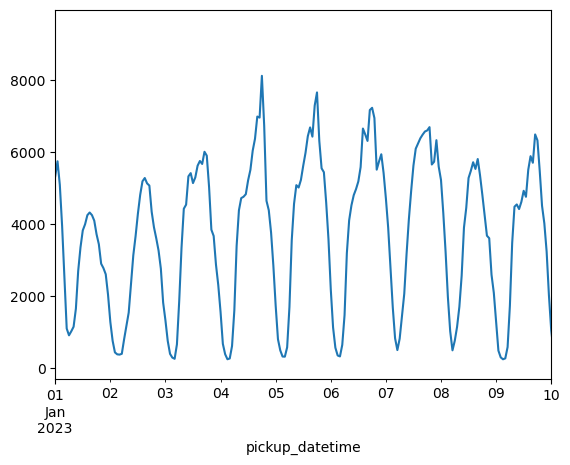

In [249]:
# convert to hourly time series
ts_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size() # note, we can try different "bin sizes" (e.g., '15min', 'D', etc.)
print(ts_y.head())

# plot hourly time series
ts_y.plot()
plt.xlim('2023-01-01', '2023-01-10')

In [250]:
# count number of pickups per hour 
ts_h_y = df_y.set_index('pickup_datetime').groupby(pd.Grouper(freq='h')).size()
ts_H_y= ts_h_y.to_frame(name = 'counts')
ts_H_y.head()

,counts
pickup_datetime,
2023-01-01 00:00:00,5336
2023-01-01 01:00:00,5752
2023-01-01 02:00:00,5097
2023-01-01 03:00:00,3952
2023-01-01 04:00:00,2501


### group counts by hour and timezone

In [251]:
# count by taxi zone
ts_h_y_z = df_y.set_index('pickup_datetime').groupby(['PULocationID', pd.Grouper(freq='h')]).size()
ts_H_y_z = ts_h_y_z.to_frame(name = 'counts')
ts_H_y_z.head()

counts
PULocationID pickup_datetime            
1            2023-01-01 05:00:00       1
             2023-01-01 08:00:00       1
             2023-01-01 11:00:00       1
             2023-01-01 12:00:00       3
             2023-01-01 13:00:00       4

### Filling in missing hours with zeros

In [252]:
# unstacking the matrix returns the missing dates as NaN
ts_H_y_z = ts_H_y_z.unstack(level=0)
ts_H_y_z.head()

counts                                           ...  \
PULocationID           1   2   3     4   5   6     7   8   9    10   ...   
pickup_datetime                                                      ...   
2023-01-01 00:00:00    NaN NaN NaN  19.0 NaN NaN   3.0 NaN NaN  NaN  ...   
2023-01-01 01:00:00    NaN NaN NaN  28.0 NaN NaN  16.0 NaN NaN  NaN  ...   
2023-01-01 02:00:00    NaN NaN NaN  43.0 NaN NaN  28.0 NaN NaN  1.0  ...   
2023-01-01 03:00:00    NaN NaN NaN  33.0 NaN NaN  21.0 NaN NaN  NaN  ...   
2023-01-01 04:00:00    NaN NaN NaN  12.0 NaN NaN  12.0 NaN NaN  1.0  ...   

                                                                             
PULocationID          256  257  258 259  260   261   262    263   264   265  
pickup_datetime                                                              
2023-01-01 00:00:00  11.0  NaN  NaN NaN  1.0  13.0  66.0  212.0  72.0   5.0  
2023-01-01 01:00:00  27.0  NaN  NaN NaN  2.0  21.0  51.0  242.0  60.0  10.0  
2023-01-01 02:00:00  24.0  2.0  NaN NaN  6.0  31.0  28.0  188.0  59.0   8.0  
2023-01-01 03:00:00  35.0  NaN  NaN NaN  3.0  16.0  14.0  123.0  53.0   8.0  
2023-01-01 04:00:00  10.0  NaN  1.0 NaN  2.0   9.0  13.0   54.0  27.0   4.0  

[5 rows x 257 columns]

In [253]:
# fill missing values with 0
ts_H_y_z = ts_H_y_z.fillna(0)
ts_H_y_z.head()

counts                                                 \
PULocationID           1    2    3     4    5    6     7    8    9    10    
pickup_datetime                                                             
2023-01-01 00:00:00    0.0  0.0  0.0  19.0  0.0  0.0   3.0  0.0  0.0  0.0   
2023-01-01 01:00:00    0.0  0.0  0.0  28.0  0.0  0.0  16.0  0.0  0.0  0.0   
2023-01-01 02:00:00    0.0  0.0  0.0  43.0  0.0  0.0  28.0  0.0  0.0  1.0   
2023-01-01 03:00:00    0.0  0.0  0.0  33.0  0.0  0.0  21.0  0.0  0.0  0.0   
2023-01-01 04:00:00    0.0  0.0  0.0  12.0  0.0  0.0  12.0  0.0  0.0  1.0   

                     ...                                                     \
PULocationID         ...   256  257  258  259  260   261   262    263   264   
pickup_datetime      ...                                                      
2023-01-01 00:00:00  ...  11.0  0.0  0.0  0.0  1.0  13.0  66.0  212.0  72.0   
2023-01-01 01:00:00  ...  27.0  0.0  0.0  0.0  2.0  21.0  51.0  242.0  60.0   
2023-01-01 02:00:00  ...  24.0  2.0  0.0  0.0  6.0  31.0  28.0  188.0  59.0   
2023-01-01 03:00:00  ...  35.0  0.0  0.0  0.0  3.0  16.0  14.0  123.0  53.0   
2023-01-01 04:00:00  ...  10.0  0.0  1.0  0.0  2.0   9.0  13.0   54.0  27.0   

                           
PULocationID          265  
pickup_datetime            
2023-01-01 00:00:00   5.0  
2023-01-01 01:00:00  10.0  
2023-01-01 02:00:00   8.0  
2023-01-01 03:00:00   8.0  
2023-01-01 04:00:00   4.0  

[5 rows x 257 columns]

In [254]:
# stack the matrix to get the original format
# if we don't specify the timezone, the printed datetime will not display the
# hourly information; however, .index shows that hourly information is present
ts_H_y_z.index = ts_H_y_z.index.tz_localize('America/New_York')
ts_H_y_z.index[0].tz
ts_H_y_z = ts_H_y_z.stack(dropna = False)
ts_H_y_z.head()

/tmp/ipykernel_11751/2262977311.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ts_H_y_z = ts_H_y_z.stack(dropna = False)


counts
pickup_datetime           PULocationID        
2023-01-01 00:00:00-05:00 1                0.0
                          2                0.0
                          3                0.0
                          4               19.0
                          5                0.0

### Reformat to a simple dataframe
In Tableau, we think of the location as the main index. Let's swap the datetime and LocationID

In [255]:
ts_H_y_z = ts_H_y_z.swaplevel()
ts_H_y_z

,,counts
PULocationID,pickup_datetime,
1,2023-01-01 00:00:00-05:00,0.0
2,2023-01-01 00:00:00-05:00,0.0
3,2023-01-01 00:00:00-05:00,0.0
4,2023-01-01 00:00:00-05:00,19.0
5,2023-01-01 00:00:00-05:00,0.0
...,...,...
261,2023-01-31 23:00:00-05:00,5.0
262,2023-01-31 23:00:00-05:00,11.0
263,2023-01-31 23:00:00-05:00,41.0


finally, let's remove the weird stacked structure. Let's make this data frame with only rows and columns

In [256]:
ts_H_y_z = ts_H_y_z.reset_index()
ts_H_y_z

,PULocationID,pickup_datetime,counts
0,1,2023-01-01 00:00:00-05:00,0.0
1,2,2023-01-01 00:00:00-05:00,0.0
2,3,2023-01-01 00:00:00-05:00,0.0
3,4,2023-01-01 00:00:00-05:00,19.0
4,5,2023-01-01 00:00:00-05:00,0.0
...,...,...,...
191203,261,2023-01-31 23:00:00-05:00,5.0
191204,262,2023-01-31 23:00:00-05:00,11.0
191205,263,2023-01-31 23:00:00-05:00,41.0
191206,264,2023-01-31 23:00:00-05:00,40.0


In [261]:
# save this as a csv file
ts_H_y_z.to_csv('../assets/tableau/yellow_taxi_2023_01_hourly.csv', index = False)

### Tableau Public
At this point, we just load the taxi SHAPE files and this dataset in Tableau. All we need to do is `JOIN` both datasets. 

1. Load both datasets in `Data Source` via `Connections`
2. `JOIN` datasets following https://help.tableau.com/current/pro/desktop/en-us/joining_tables.htm

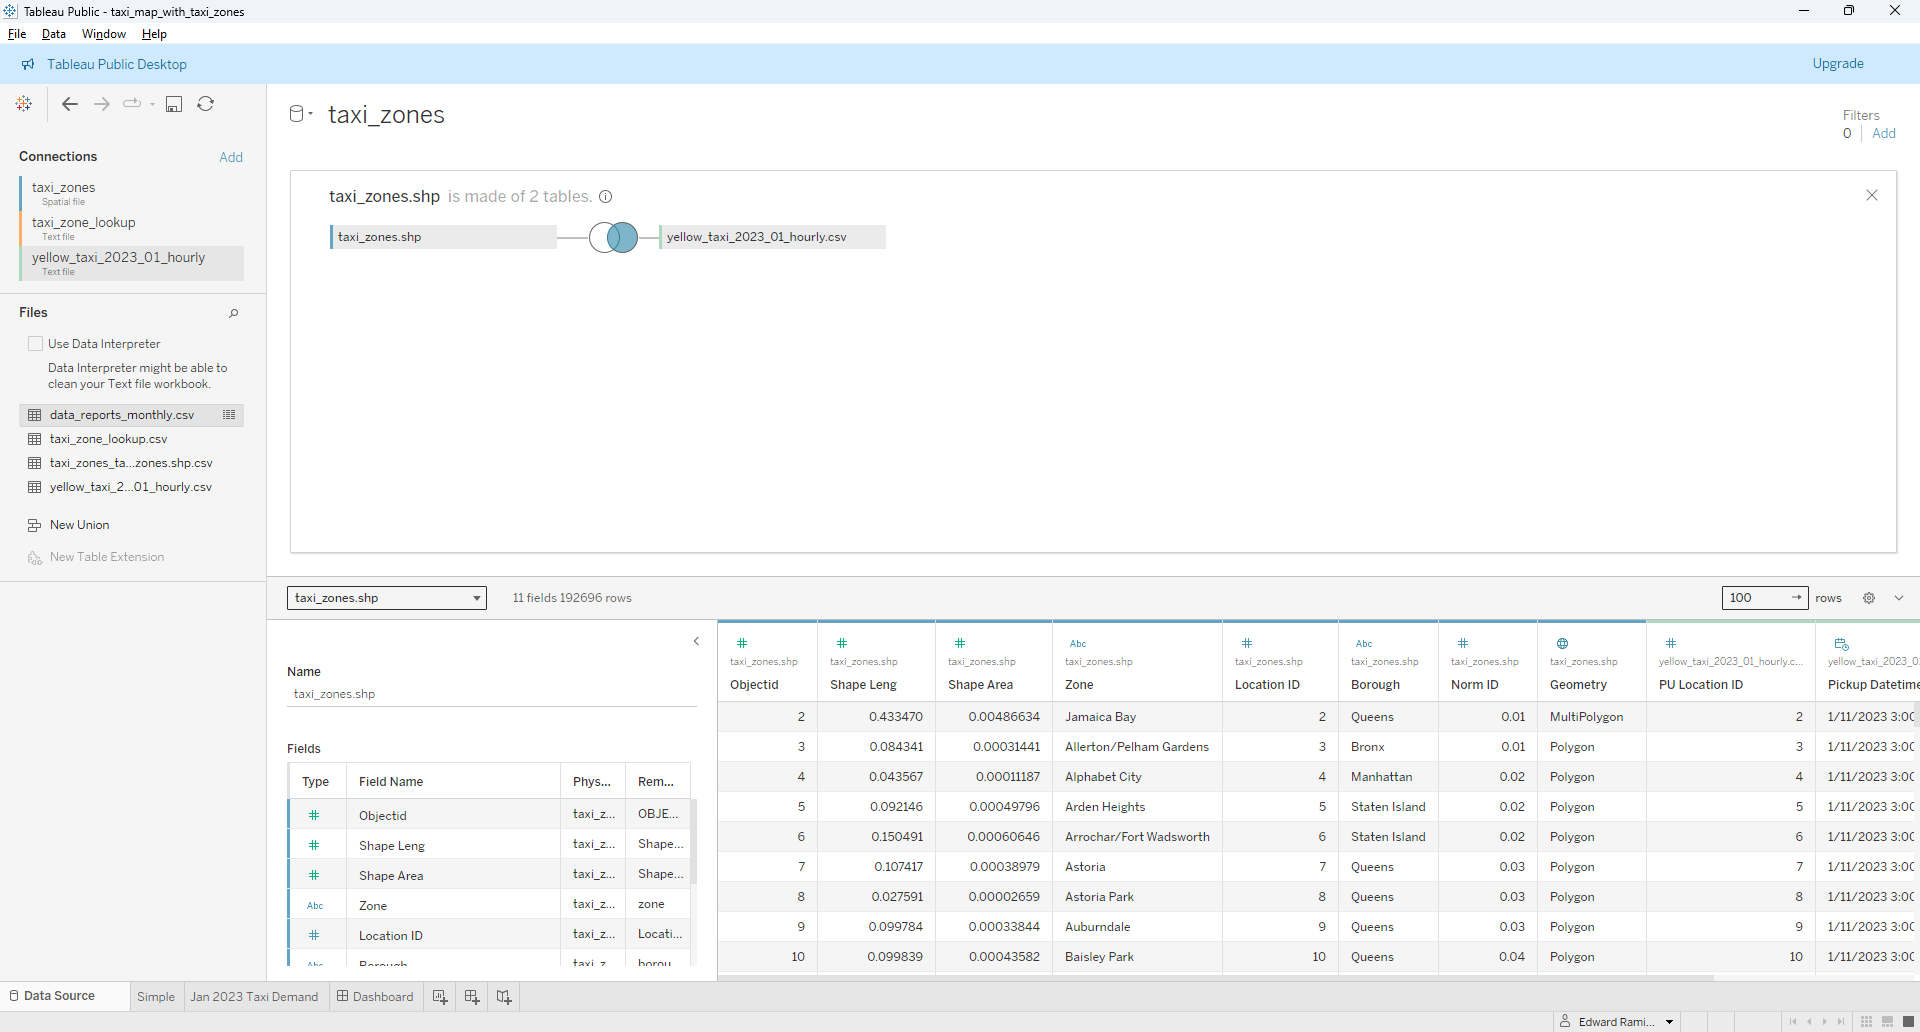

3. Dates will load as strings, convert to date & time in merged dataset https://help.tableau.com/current/pro/desktop/en-us/data_dateparse.htm

3. Make map using the settings from image below

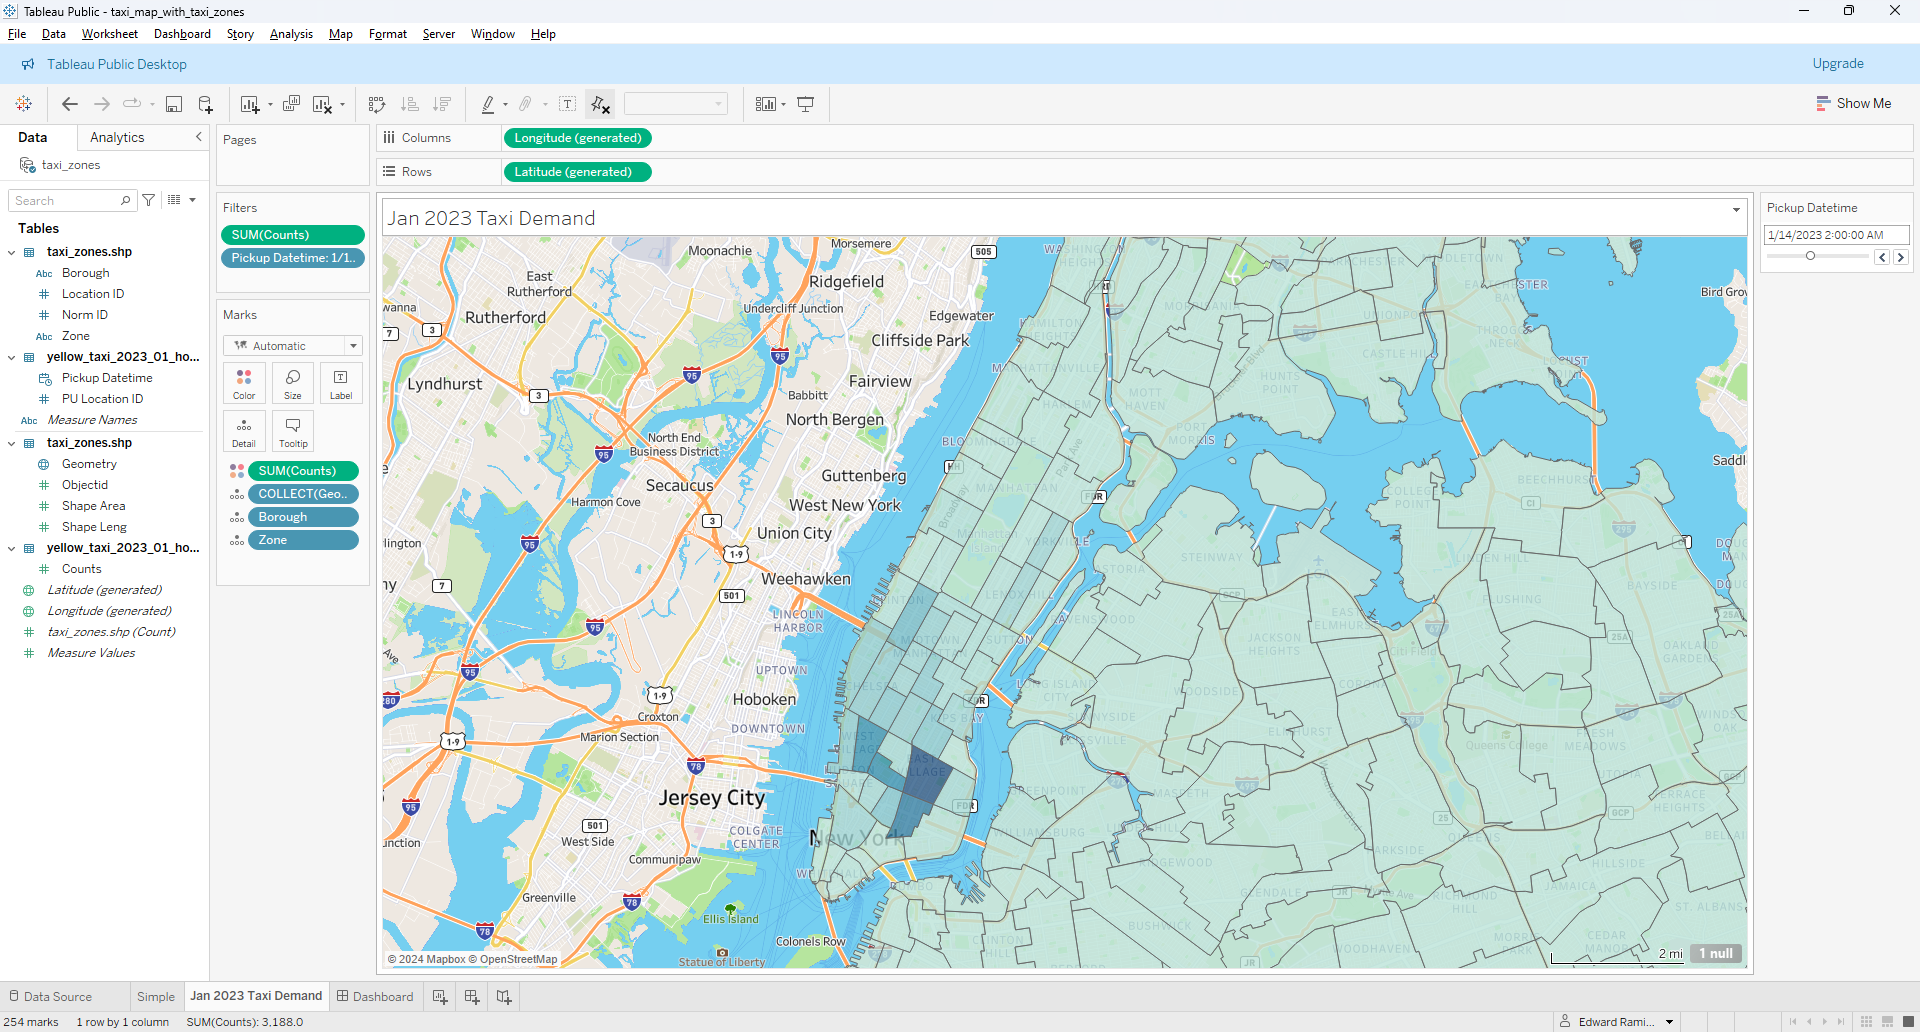

4. Show time slider filter by clicking the drop-down on the time filter and clicking "Show Filter"

5. Make a dashboard, drag & drop worksheet, edit as you like.

6. Publish on Tableau Public to give other team-members access https://public.tableau.com/app/profile/edward.ramirez/viz/taxi_map_with_taxi_zones/Dashboard?publish=yes

### setting more custom dates
This would be during the step where you have an index of only dates (after `unstack`).

In [205]:
# fill missing values with 0
index = pd.date_range(start = ts_H_y_z.index.min(), end = ts_H_y_z.index.max(), freq = 'h')
ts_H_y_z = ts_H_y_z.reindex(index, fill_value = 0.0).fillna(0.0)

### sparsity of some taxi zones

In [267]:
df_H_y_z_1 = ts_H_y_z[ts_H_y_z['PULocationID'] == 1]

In [268]:
df_H_y_z_1

,PULocationID,pickup_datetime,counts
0,1,2023-01-01 00:00:00-05:00,0.0
257,1,2023-01-01 01:00:00-05:00,0.0
514,1,2023-01-01 02:00:00-05:00,0.0
771,1,2023-01-01 03:00:00-05:00,0.0
1028,1,2023-01-01 04:00:00-05:00,0.0
...,...,...,...
189923,1,2023-01-31 19:00:00-05:00,0.0
190180,1,2023-01-31 20:00:00-05:00,0.0
190437,1,2023-01-31 21:00:00-05:00,0.0
190694,1,2023-01-31 22:00:00-05:00,0.0


(464592.0, 464808.0)

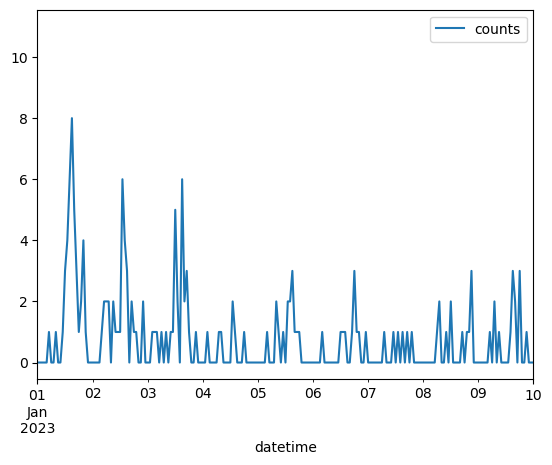

In [269]:
ts_H_y_z_1.plot(x = 'datetime', y = 'counts')
plt.xlim('2023-01-01', '2023-01-10')